In [1]:
 !pip install httpx[http2] parsel nested_lookup

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.8 MB/s eta 0:00:00
  Created wheel for nested_lookup: filename=nested_lookup-0.2.25-py3-none-any.whl size=13162 sha256=07bc57d8e2ec71b14e8f7e0c2ca36f99a20f42db80e439a662fe389540418e42
  Stored in directory: /root/.cache/pip/wheels/f9/d6/89/e04a9116dbc5fe6fd7112b9d60051224595d8370433fb43759
Successfully built nested_lookup


# Scraping

## Konfiguráció

In [ ]:
import json
import httpx
from parsel import Selector

# establish our HTTP2 client with browser-like headers
session = httpx.Client(
    headers={
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36 Edg/113.0.1774.35",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
        "Accept-Language": "en-US,en;q=0.9",
        "Accept-Encoding": "gzip, deflate, br",
    },
    http2=True,
    follow_redirects=True
)

## Termék URL-ek megszerzése

In [21]:
from urllib.parse import urlencode

SORTING_MAP = {
    "best_match": 12,
    "ending_soonest": 1,
    "newly_listed": 10,
}

def parse_search(response: httpx.Response):
    """parse ebay's search page for listing preview details"""
    urls = []
    # each listing has it's own HTML box where all of the data is contained
    sel = Selector(response.text)
    listing_boxes = sel.css(".srp-results li.s-item")
    for box in listing_boxes:
        # quick helpers to extract first element and all elements
        css = lambda css: box.css(css).get("").strip()
        css_all = lambda css: box.css(css).getall()
        urls.append(css("a.s-item__link::attr(href)").split("?")[0])
    return urls


def scrape_search(
    query,
    max_pages=1,
    category=0,
    items_per_page=120,
    sort="best_match"):
    """Scrape Ebay's search results page for product preview data for given"""

    def make_request(page):
        return "https://www.ebay.com/sch/i.html?" + urlencode(
            {
                "_nkw": query,
                "_sacat": category,
                "_ipg": items_per_page,
                "_sop": SORTING_MAP[sort],
                "_pgn": page,
            }
        )

    first_page = session.get(make_request(page=1))
    results = parse_search(first_page)
    return results

data = scrape_search("laptop")
print(data)

['https://www.ebay.com/itm/256613921973', 'https://www.ebay.com/itm/276399334462', 'https://www.ebay.com/itm/314632691574', 'https://www.ebay.com/itm/256195038210', 'https://www.ebay.com/itm/326084221424', 'https://www.ebay.com/itm/264290279789', 'https://www.ebay.com/itm/256563746842', 'https://www.ebay.com/itm/204735219720', 'https://www.ebay.com/itm/235710126308', 'https://www.ebay.com/itm/315132025331', 'https://www.ebay.com/itm/196493480680', 'https://www.ebay.com/itm/115616083337', 'https://www.ebay.com/itm/204883709578', 'https://www.ebay.com/itm/196416268162', 'https://www.ebay.com/itm/264290279789', 'https://www.ebay.com/itm/315560374504', 'https://www.ebay.com/itm/204705619254', 'https://www.ebay.com/itm/166907826925', 'https://www.ebay.com/itm/196305942422', 'https://www.ebay.com/itm/305435159923', 'https://www.ebay.com/itm/204705618685', 'https://www.ebay.com/itm/276553848429', 'https://www.ebay.com/itm/266068225631', 'https://www.ebay.com/itm/266875723246', 'https://www.eb

In [22]:
len(data)

145

## Termék információk megszerzése

In [5]:

def parse_product(response: httpx.Response) -> dict:
    """Parse Ebay's product listing page for core product data"""
    sel = Selector(response.text)
    # define helper functions that chain the extraction process
    css_join = lambda css: "".join(sel.css(css).getall()).strip()  # join all selected elements
    css = lambda css: sel.css(css).get("").strip()  # take first selected element and strip of leading/trailing spaces

    item = {}
    item["url"] = css('link[rel="canonical"]::attr(href)')
    item["id"] = item["url"].split("/itm/")[1].split("?")[0]  # we can take ID from the URL
    item["price_original"] = css(".x-price-primary>span::text")
    item["price_converted"] = css(".x-price-approx__price ::text")  # ebay automatically converts price for some regions
    item["name"] = css_join("h1 span::text")

    # feature details from the description table:
    features = {}
    feature_table = sel.css("div.ux-layout-section--features")
    for feature in feature_table.css("dl.ux-labels-values"):
        # iterate through each label of the table and select first sibling for value:
        label = "".join(feature.css(".ux-labels-values__labels-content > div > span::text").getall()).strip(":\n ")
        value = "".join(feature.css(".ux-labels-values__values-content > div > span *::text").getall()).strip(":\n ")
        features[label] = value
    item["features"] = features

    return item


{
  "url": "https://www.ebay.com/itm/285636515887",
  "id": "285636515887",
  "price_original": "US $149.95",
  "price_converted": "",
  "name": "Apple AirPods Pro 2nd Generation Gen 2 2023 A2968 with Magsafe USB-C Charging",
  "description_url": "https://vi.vipr.ebaydesc.com/itmdesc/285636515887?t=1717186008000&category=80077&seller=pezzs_inc&excSoj=1&ver=0&excTrk=1&lsite=0&ittenable=true&domain=ebay.com&descgauge=1&cspheader=1&oneClk=2&secureDesc=1",
  "features": {
    "Condition": "Excellent - Refurbished: The item is in like-new condition, backed by a one year warranty. It has ...  Read moreabout the conditionExcellent - Refurbished: The item is in like-new condition, backed by a one year warranty. It has been professionally refurbished, inspected and cleaned to excellent condition by qualified sellers. The item includes original or new accessories and will come in new generic packaging. See the seller's listing for full details. See all condition definitionsopens in a new window 

In [23]:
import time

In [31]:
import tqdm

In [33]:
# parse product and save jsons to list
list_products = []
for url in tqdm.tqdm(data):
  response = session.get(url)
  time.sleep(3)
  product_data = parse_product(response)
  list_products.append(product_data)

100%|██████████| 145/145 [09:28<00:00,  3.92s/it]


In [ ]:
import pickle

In [2]:
# save the list to a pickle file

# filehandler = open(b"list_products.p","wb")
# pickle.dump(list_products,filehandler)

NameError: name 'list_products' is not defined


# Adattisztítás

In [3]:
import pickle

In [4]:
# load back the data
with open("list_products.p", 'rb') as f:
    list_products = pickle.load(f)

In [5]:
import pandas as pd

In [6]:
# create df
df_products = pd.DataFrame.from_dict(list_products)

In [7]:
df_products.describe()

,url,id,price_original,price_converted,name,description_url,features
count,145,145,145,145,145,145,145
unique,138,138,111,1,138,138,137
top,https://www.ebay.com/itm/295907273733,295907273733,US $119.99,,HP 17.3 FHD Notebook AMD Ryzen 5 5500U 8GB RA...,https://vi.vipr.ebaydesc.com/itmdesc/295907273...,"{'Condition': 'New: A brand-new, unused, unope..."
freq,2,2,5,145,2,2,2


In [8]:
df_products = df_products.drop_duplicates('url').reset_index(drop=True)

In [9]:
df_products.describe()

,url,id,price_original,price_converted,name,description_url,features
count,138,138,138,138,138,138,138
unique,138,138,111,1,138,138,137
top,https://www.ebay.com/itm/256613921973,256613921973,US $119.99,,HP 14” Laptop Intel Core i5 2.3GHz 16GB RAM 51...,https://vi.vipr.ebaydesc.com/itmdesc/256613921...,"{'Condition': 'Used', 'Seller Notes': '“All Ch..."
freq,1,1,5,138,1,1,2


In [10]:
df_products['feature_keys'] = df_products.loc[:,'features'].apply(lambda x: set(x.keys()))
df_products['num_feature_keys'] = df_products.loc[:,'features'].apply(lambda x: len(x.keys()))

In [11]:
df_products['num_feature_keys'].describe()

,num_feature_keys
count,138.000000
mean,22.485507
std,8.198483
min,7.000000
25%,16.000000
50%,22.000000
75%,28.750000
max,44.000000


In [12]:
# check feature intersection and union
intersect = set.intersection(*df_products['feature_keys'].values)
union = set.union(*df_products['feature_keys'].values)

In [13]:
intersect

{'Brand', 'Condition'}

In [14]:
len(union)

128

Ötlet: Amit még itt meg lehetne csinálni, hogy végignézem van-e esetleg olyan feature, ami valójában megegyezik egy másikkal, csak kicsit más a neve.

In [15]:
# clean price data
df_products['price_num'] = df_products['price_original'].str.split(' ',expand=True)[1].str.split('/',expand=True)[0].str.replace('$','').str.replace(',','').astype(float)

In [16]:
# drop outliers
df_products_filt = df_products.loc[df_products['price_num']<1000,['id', 'price_num', 'features']].reset_index(drop=True).copy()

In [17]:
len(df_products_filt)

135

In [18]:
df_features = pd.DataFrame.from_dict(list(df_products_filt['features'].values))

In [19]:
df_features_not_na = (~df_features.isna()).sum().reset_index().rename(columns={0:'count'})

In [20]:
# at least 80 product has this feature
list_of_common_features = df_features_not_na.loc[df_features_not_na['count']>=80,'index'].values

In [21]:
df_features_filt = df_features.loc[:,list_of_common_features].copy()

In [22]:
df_products_filt_w_features = df_products_filt.merge(df_features_filt,left_index=True,right_index=True)

Jegyzet: A "Seller Notes" változóra rá lehetne esetleg menni valamilyen szövegelemzéssel, akár kulcsszavakat vagy negatív kifejezéseket kigyűjteni, hátha van hozzáadott értéke.

In [23]:
for col in list_of_common_features:
  print(col)
  print(df_products_filt_w_features[col].nunique())
  print(df_products_filt_w_features[col].value_counts())
  print('----------')
  print()

Condition
11
Condition
Used                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       47
New: A brand-new, unused, unopened, undamaged item in its original packaging (where packaging is ...  Read moreabout the conditionNew: A brand-new, unused, unopened, undamaged item in its original packaging (where packaging is applicable). Packaging should be the same as what is found in a retail store, unless the item is handmade or was packaged by the manufacturer in non-retail packaging, such as an unprinted box or plastic bag. 

**Tisztítási lépések:**
mindenhol hiányzóérték pótlás

* Condition: szöveg vágás
* Seller Notes: kidob
* Processor: csoportosít
* SSD Capacity: tisztít, csoportosít
* GPU: csoportosít
* Operating System: tisztít, other
* Features: kidob (nem tűnik hasznosnak)
* Screen Size: szám, csoportosít
* Color: kidob
* RAM Size: szám, csoportosít
* Processor Speed: szám, csoportosít
* Brand: other
* Series: brand mellet nincs sok értelme (túl sok érték)
* Type: kidob, szinte ugyanaz
* Maximum Resolution: tisztít, csoportosít
* Model: kidob, túl specifikus
* Connectivity: kidob (nincs időm kitisztítani)
* Storage Type: tisztít, csoportosít
* UPC: kidob, azonosító
* MPN: kidob, túl specifikus




In [24]:
len(list_of_common_features)

20

In [25]:
drop_features = ['Seller Notes','Features','Color','Type','Model','UPC','MPN','Series','Connectivity']

In [26]:
series_row_notna_num = (~df_products_filt_w_features[list(set(list_of_common_features).difference(set(drop_features)))].isna()).sum(axis=1)

In [27]:
# rows where at least 8 feature has value from 12 features
keep_rows = series_row_notna_num[series_row_notna_num>7].index

In [28]:
df_products_filt_w_features_filt = df_products_filt_w_features.drop(drop_features,axis=1)
df_products_filt_w_features_filt = df_products_filt_w_features_filt.loc[keep_rows,:].reset_index(drop=True).copy()

In [29]:
len(df_products_filt_w_features_filt)

121

In [30]:
import numpy as np

In [31]:
df_products_filt_w_features_filt['Condition_categ'] = df_products_filt_w_features_filt['Condition'].str.split(':',expand=True)[0]
df_products_filt_w_features_filt['Condition_categ'].value_counts()

,count
Condition_categ,
Used,48
New,24
Very Good - Refurbished,20
Certified - Refurbished,16
Good - Refurbished,8
Excellent - Refurbished,4
Open box,1


In [32]:
df_products_filt_w_features_filt['Condition_categ'].isna().sum()

0

In [33]:
df_products_filt_w_features_filt['Processor'] = df_products_filt_w_features_filt['Processor'].replace("Intel or AMD",np.NaN)

# based on going through values
df_products_filt_w_features_filt.loc[:,'Processor_categ'] = 'Intel Core Other'
df_products_filt_w_features_filt.loc[df_products_filt_w_features_filt['Processor'].fillna('').str.lower().str.contains('i5'),'Processor_categ'] = 'Intel Core i5'
df_products_filt_w_features_filt.loc[df_products_filt_w_features_filt['Processor'].fillna('').str.lower().str.contains('i7'),'Processor_categ'] = 'Intel Core i7'
df_products_filt_w_features_filt.loc[df_products_filt_w_features_filt['Processor'].fillna('').str.lower().str.contains('celeron'),'Processor_categ'] = 'Intel Celeron'
df_products_filt_w_features_filt.loc[df_products_filt_w_features_filt['Processor'].fillna('').str.lower().str.contains('pentium'),'Processor_categ'] = 'Intel Pentium'
df_products_filt_w_features_filt.loc[df_products_filt_w_features_filt['Processor'].fillna('').str.lower().str.contains('ryzen'),'Processor_categ'] = 'AMD Ryzen'
# most common
df_products_filt_w_features_filt.loc[df_products_filt_w_features_filt['Processor'].isna(),'Processor_categ'] = 'Intel Core i5'

df_products_filt_w_features_filt['Processor_categ'].value_counts()

,count
Processor_categ,
Intel Core i5,46
Intel Celeron,32
Intel Core i7,16
Intel Core Other,13
Intel Pentium,7
AMD Ryzen,7


In [34]:
print(df_products_filt_w_features_filt['Processor'].isna().sum())
print(df_products_filt_w_features_filt['Processor_categ'].isna().sum())

1
0


ChatGPT alapján "7520U" is Intel Core.

In [35]:
df_products_filt_w_features_filt.loc[df_products_filt_w_features_filt['Processor_categ']=='Intel Core Other','Processor']

,Processor
3,7320U
17,Intel 12th Generation Core i3
19,Intel 12th Generation Core i3
20,i3-N305
22,7520U
24,Intel 12th Generation Core i3
37,Intel Core M3
51,7520U
76,7520U
85,i3-1215U


In [36]:
remove = ['GB','gigabytes','Not Applicable','eMMC','Up to ']
df_products_filt_w_features_filt['SSD Capacity_cl'] = df_products_filt_w_features_filt['SSD Capacity'].copy()
for st in remove:
  df_products_filt_w_features_filt['SSD Capacity_cl'] = df_products_filt_w_features_filt['SSD Capacity_cl'].str.replace(st,'')
df_products_filt_w_features_filt['SSD Capacity_cl'] = df_products_filt_w_features_filt['SSD Capacity_cl'].str.replace('1 TB','1024').str.replace('1TB','1024').str.replace('1000','1024').str.replace('500','512')
df_products_filt_w_features_filt['SSD Capacity_cl'] = df_products_filt_w_features_filt['SSD Capacity_cl'].str.strip()


dict_replace_ssd = {'':np.NaN,'0':np.NaN,'16':0,'32':0,'64':0,'128':1,'256':2,'512':3,'1024':4}

df_products_filt_w_features_filt['SSD Capacity_ordinal'] = df_products_filt_w_features_filt['SSD Capacity_cl'].copy()

for k in dict_replace_ssd.keys():
  df_products_filt_w_features_filt['SSD Capacity_ordinal'] = df_products_filt_w_features_filt['SSD Capacity_ordinal'].replace(k,dict_replace_ssd[k])

# middle value
df_products_filt_w_features_filt['SSD Capacity_ordinal'].fillna(2,inplace=True)
df_products_filt_w_features_filt['SSD Capacity_ordinal'].value_counts()

,count
SSD Capacity_ordinal,
2.0,47
1.0,26
3.0,24
0.0,13
4.0,11


In [37]:
print(df_products_filt_w_features_filt['SSD Capacity'].isna().sum())
print(df_products_filt_w_features_filt['SSD Capacity_ordinal'].isna().sum())

10
0


In [38]:
remove = ['GB','Up to ']
df_products_filt_w_features_filt['RAM Size_cl'] = df_products_filt_w_features_filt['RAM Size'].copy()
for st in remove:
  df_products_filt_w_features_filt['RAM Size_cl'] = df_products_filt_w_features_filt['RAM Size_cl'].str.replace(st,'')
df_products_filt_w_features_filt['RAM Size_cl'] = df_products_filt_w_features_filt['RAM Size_cl'].str.strip()


dict_replace_ram = {'4':0,'8':1,'16':2,'20':3,'24':3,'32':3,'256':3}

df_products_filt_w_features_filt['RAM Size_ordinal'] = df_products_filt_w_features_filt['RAM Size_cl'].copy()

for k in dict_replace_ram.keys():
  df_products_filt_w_features_filt['RAM Size_ordinal'] = df_products_filt_w_features_filt['RAM Size_ordinal'].replace(k,dict_replace_ram[k])
# middle/common value
df_products_filt_w_features_filt['RAM Size_ordinal'].fillna(1,inplace=True)

df_products_filt_w_features_filt['RAM Size_ordinal'].value_counts()

,count
RAM Size_ordinal,
1.0,60
2.0,26
0.0,26
3.0,9


In [39]:
print(df_products_filt_w_features_filt['RAM Size'].isna().sum())
print(df_products_filt_w_features_filt['RAM Size_ordinal'].isna().sum())

16
0


In [40]:
remove = ['GHz','Ghz','Up to ','Intel Core i5-1145G7','ghz or more']
df_products_filt_w_features_filt['Processor Speed_cl'] = df_products_filt_w_features_filt['Processor Speed'].str.replace('2.00 GHz up to 4.50 GHz','4.50 GHz').copy()
for st in remove:
  df_products_filt_w_features_filt['Processor Speed_cl'] = df_products_filt_w_features_filt['Processor Speed_cl'].str.replace(st,'')
df_products_filt_w_features_filt['Processor Speed_cl'] = df_products_filt_w_features_filt['Processor Speed_cl'].str.strip().replace('',np.NaN).astype(float)

df_products_filt_w_features_filt['Processor Speed_ordinal'] = pd.cut(df_products_filt_w_features_filt['Processor Speed_cl'],bins=[-np.Infinity,1.6,2.2,2.6,3,np.Infinity],labels=[0,1,2,3,4])
# middle value
df_products_filt_w_features_filt['Processor Speed_ordinal'].fillna(2,inplace=True)

df_products_filt_w_features_filt['Processor Speed_ordinal'].value_counts()

,count
Processor Speed_ordinal,
2,49
0,32
1,14
3,14
4,12


In [41]:
print(df_products_filt_w_features_filt['Processor Speed'].isna().sum())
print(df_products_filt_w_features_filt['Processor Speed_ordinal'].isna().sum())

21
0


Ötlet: lehet, hogy a nagyobb screensize nem feltétlenül drágább, szóval ez lehet, hogy kategórikusként is ki lehetne próbálni

In [42]:
remove = ['inches','in.','in','"']
df_products_filt_w_features_filt['Screen Size_cl'] = df_products_filt_w_features_filt['Screen Size'].copy()
for st in remove:
  df_products_filt_w_features_filt['Screen Size_cl'] = df_products_filt_w_features_filt['Screen Size_cl'].str.replace(st,'')
df_products_filt_w_features_filt['Screen Size_cl'] = df_products_filt_w_features_filt['Screen Size_cl'].str.strip().replace('',np.NaN).astype(float)


df_products_filt_w_features_filt['Screen Size_ordinal'] = pd.cut(df_products_filt_w_features_filt['Screen Size_cl'],bins=[-np.Infinity,11.7,13.5,14.1,np.Infinity],labels=[0,1,2,3])

# middle/common value
df_products_filt_w_features_filt['Screen Size_ordinal'].fillna(2,inplace=True)

df_products_filt_w_features_filt['Screen Size_ordinal'].value_counts()

,count
Screen Size_ordinal,
3,42
2,40
0,27
1,12


In [43]:
print(df_products_filt_w_features_filt['Screen Size'].isna().sum())
print(df_products_filt_w_features_filt['Screen Size_ordinal'].isna().sum())

0
0


In [44]:
list_brand = ['Dell','HP','Lenovo','Acer']
df_products_filt_w_features_filt['Brand_categ'] = df_products_filt_w_features_filt['Brand'].copy()
df_products_filt_w_features_filt.loc[~df_products_filt_w_features_filt['Brand'].isin(list_brand),'Brand_categ'] = 'Other'
df_products_filt_w_features_filt['Brand_categ'].fillna('HP',inplace=True)

df_products_filt_w_features_filt['Brand_categ'].value_counts()

,count
Brand_categ,
HP,33
Dell,31
Lenovo,28
Other,18
Acer,11


In [45]:
print(df_products_filt_w_features_filt['Brand'].isna().sum())
print(df_products_filt_w_features_filt['Brand_categ'].isna().sum())

0
0


In [46]:
df_products_filt_w_features_filt['Storage Type SSD'] = False
df_products_filt_w_features_filt.loc[(df_products_filt_w_features_filt['Storage Type'].str.contains('SSD')) &
                                     ~(df_products_filt_w_features_filt['Storage Type'].isna()),'Storage Type SSD'] = True
df_products_filt_w_features_filt.loc[df_products_filt_w_features_filt['Storage Type'].isna(),'Storage Type SSD'] = True
df_products_filt_w_features_filt['Storage Type SSD'].value_counts()

,count
Storage Type SSD,
True,103
False,18


In [47]:
print(df_products_filt_w_features_filt['Storage Type'].isna().sum())
print(df_products_filt_w_features_filt['Storage Type SSD'].isna().sum())

8
0


In [48]:
remove = ['(Full HD)','(Full HD+)','(HD)','(WUXGA)']
df_products_filt_w_features_filt['Maximum Resolution_cl'] = df_products_filt_w_features_filt['Maximum Resolution'].copy()
for st in remove:
  df_products_filt_w_features_filt['Maximum Resolution_cl'] = df_products_filt_w_features_filt['Maximum Resolution_cl'].str.replace(st,'')
df_products_filt_w_features_filt['Maximum Resolution_cl'] = df_products_filt_w_features_filt['Maximum Resolution_cl'].str.replace('*',' x ').str.replace('x',' x ')
df_products_filt_w_features_filt['Maximum Resolution_cl'] = df_products_filt_w_features_filt['Maximum Resolution_cl'].str.strip()


df_products_filt_w_features_filt['Maximum Resolution Full HD or better'] = False
df_products_filt_w_features_filt.loc[((df_products_filt_w_features_filt['Maximum Resolution_cl'].str.contains('1920')) | (df_products_filt_w_features_filt['Maximum Resolution_cl'].str.contains('2560'))) &
                                     ~(df_products_filt_w_features_filt['Maximum Resolution_cl'].isna()),'Maximum Resolution Full HD or better'] = True
df_products_filt_w_features_filt.loc[df_products_filt_w_features_filt['Maximum Resolution_cl'].isna(),'Maximum Resolution Full HD or better'] = True
df_products_filt_w_features_filt['Maximum Resolution Full HD or better'].value_counts()

,count
Maximum Resolution Full HD or better,
True,74
False,47


In [49]:
print(df_products_filt_w_features_filt['Maximum Resolution'].isna().sum())
print(df_products_filt_w_features_filt['Maximum Resolution Full HD or better'].isna().sum())

19
0


In [50]:
df_products_filt_w_features_filt['GPU_categ'] = 'Intel Other'
df_products_filt_w_features_filt.loc[df_products_filt_w_features_filt['GPU'].fillna('').str.lower().str.contains('intel hd'),'GPU_categ'] = 'Intel HD'
df_products_filt_w_features_filt.loc[df_products_filt_w_features_filt['GPU'].fillna('').str.lower().str.contains('uhd'),'GPU_categ'] = 'Intel UHD'
df_products_filt_w_features_filt.loc[~(df_products_filt_w_features_filt['GPU'].fillna('').str.lower().str.contains('intel')),'GPU_categ'] = 'Other'
df_products_filt_w_features_filt.loc[df_products_filt_w_features_filt['GPU'].isna(),'GPU_categ'] = 'Intel HD'
df_products_filt_w_features_filt['GPU_categ'].value_counts()

,count
GPU_categ,
Intel HD,68
Intel UHD,33
Intel Other,10
Other,10


In [51]:
print(df_products_filt_w_features_filt['GPU'].isna().sum())
print(df_products_filt_w_features_filt['GPU_categ'].isna().sum())

28
0


In [52]:
df_products_filt_w_features_filt.loc[df_products_filt_w_features_filt['GPU_categ']=='Intel Other','GPU']

,GPU
21,Intel Iris Xe Graphics
27,Intel Iris Xe Graphics
31,intel
32,Intel Iris Xe Graphics
33,Intel Celeron N5095
47,Intel Iris Xe Graphics
55,intel
80,Intel Iris Xe Graphics
89,Intel Iris Xe Graphics
97,Intel Iris Xe Graphics


In [53]:
df_products_filt_w_features_filt.loc[df_products_filt_w_features_filt['GPU_categ']=='Other','GPU']

,GPU
44,AMD Radeon Graphics
45,AMD Radeon 780M Graphics
48,AMD Radeon Graphics
50,NVIDIA GeForce RTX 4060
63,NVIDIA GeForce RTX 2050
78,AMD Integrated Radeon 610M
83,Nvidia Quadro M620 w/2GB GDDR5
90,Integrated AMD Radeon Graphics
100,AMD Radeon Graphics
113,AMD Radeon


In [54]:
df_products_filt_w_features_filt['Operating System_categ'] = 'Other'
df_products_filt_w_features_filt.loc[df_products_filt_w_features_filt['Operating System'].fillna('').str.lower().str.contains('windows 11'),'Operating System_categ'] = 'Windows 11'
df_products_filt_w_features_filt.loc[df_products_filt_w_features_filt['Operating System'].fillna('').str.lower().str.contains('windows 10'),'Operating System_categ'] = 'Windows 10'
df_products_filt_w_features_filt.loc[df_products_filt_w_features_filt['Operating System'].fillna('').str.lower().str.contains('chrome'),'Operating System_categ'] = 'Chrome OS'
df_products_filt_w_features_filt.loc[df_products_filt_w_features_filt['Operating System'].isna(),'Operating System_categ'] = 'Windows 11'
df_products_filt_w_features_filt['Operating System_categ'].value_counts()

,count
Operating System_categ,
Windows 11,62
Windows 10,38
Chrome OS,16
Other,5


In [55]:
print(df_products_filt_w_features_filt['Operating System'].isna().sum())
print(df_products_filt_w_features_filt['Operating System_categ'].isna().sum())

3
0


# EDA

In [56]:
import seaborn as sns

In [57]:
# these are the final fetures
selected_features = ['Condition_categ',
       'Processor_categ', 'SSD Capacity_ordinal',
       'RAM Size_ordinal',
       'Processor Speed_ordinal', 'Screen Size_ordinal',
       'Brand_categ', 'Storage Type SSD',
       'Maximum Resolution Full HD or better', 'GPU_categ', 'Operating System_categ']

In [58]:
df_products_filt_w_features_filt.columns

Index(['id', 'price_num', 'features', 'Condition', 'Processor', 'SSD Capacity',
       'GPU', 'Operating System', 'Screen Size', 'RAM Size', 'Processor Speed',
       'Brand', 'Maximum Resolution', 'Storage Type', 'Condition_categ',
       'Processor_categ', 'SSD Capacity_cl', 'SSD Capacity_ordinal',
       'RAM Size_cl', 'RAM Size_ordinal', 'Processor Speed_cl',
       'Processor Speed_ordinal', 'Screen Size_cl', 'Screen Size_ordinal',
       'Brand_categ', 'Storage Type SSD', 'Maximum Resolution_cl',
       'Maximum Resolution Full HD or better', 'GPU_categ',
       'Operating System_categ'],
      dtype='object')

In [59]:
import matplotlib.pyplot as plt

<ipython-input-60-bb55fd5c50ce>:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_products_filt_w_features_filt,x='price_num',hue=feature,cut=0)


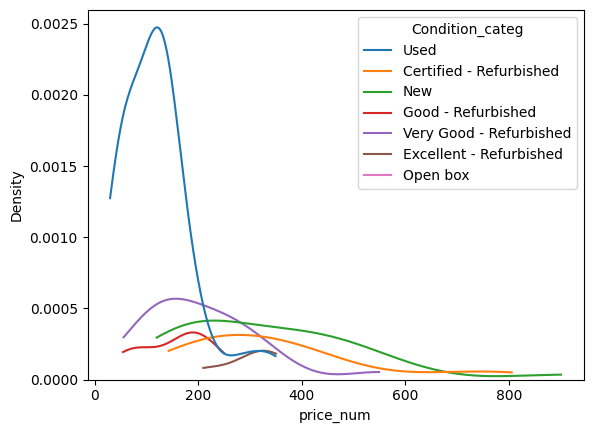

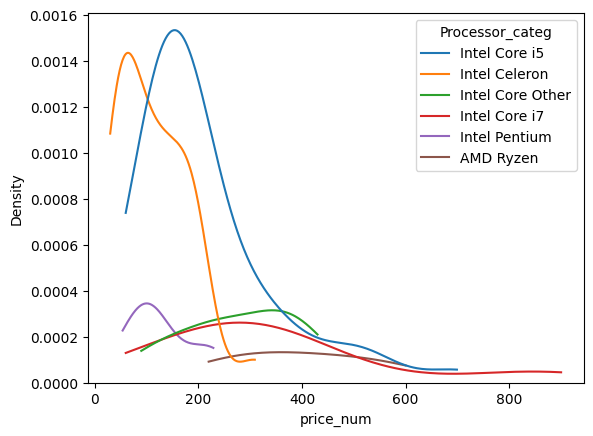

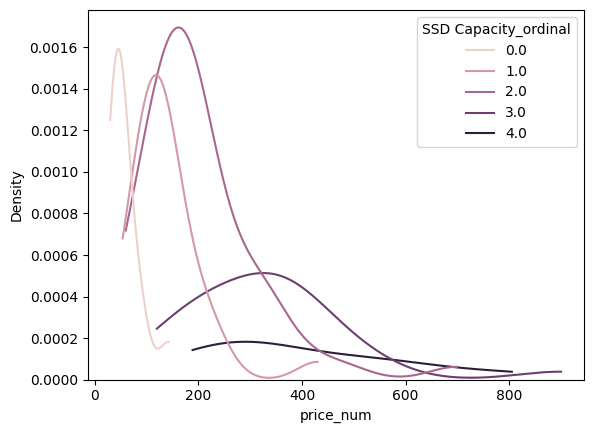

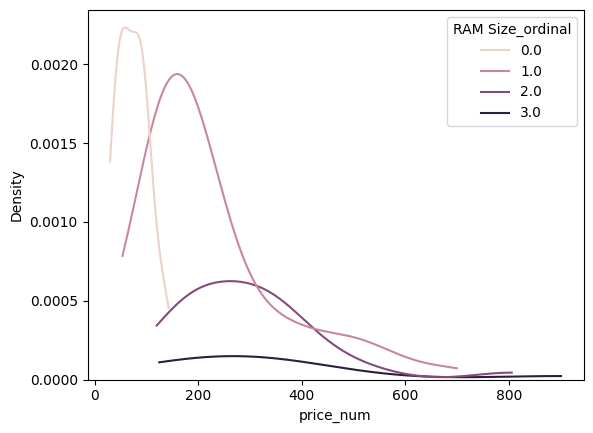

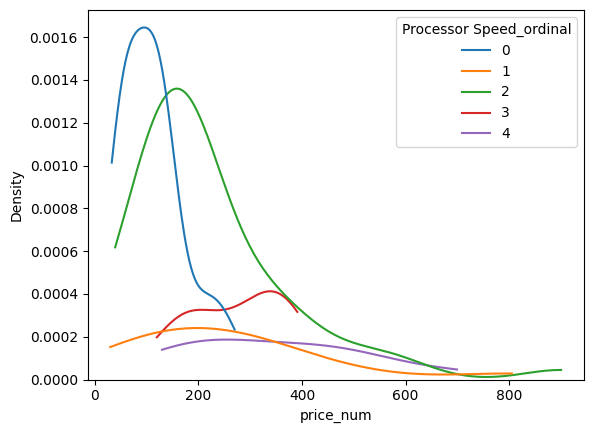

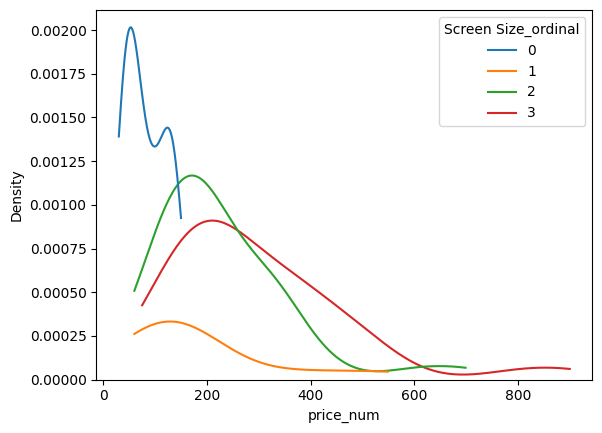

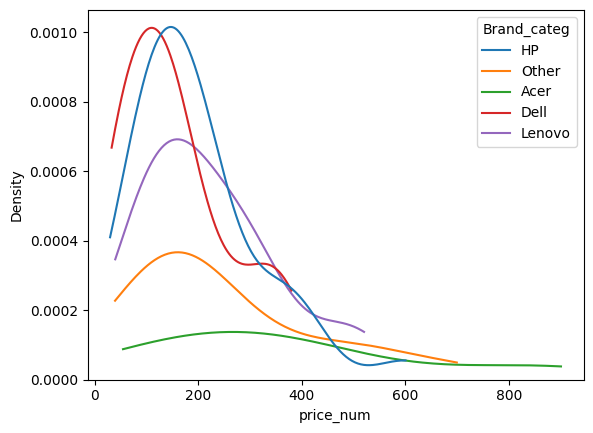

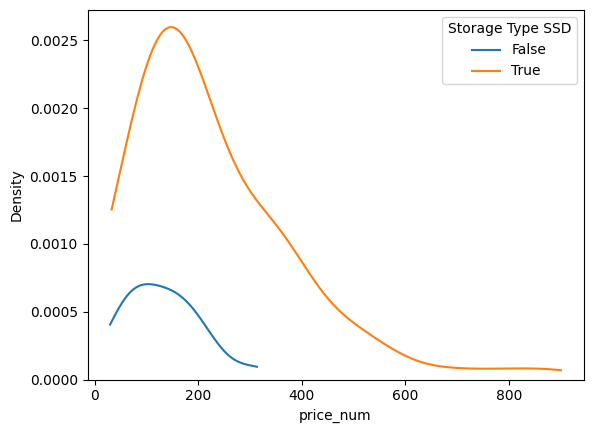

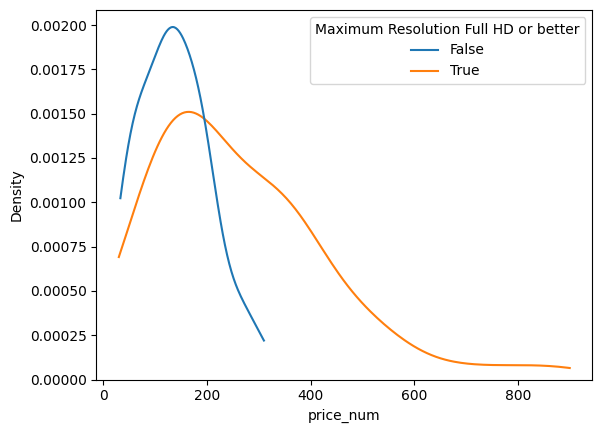

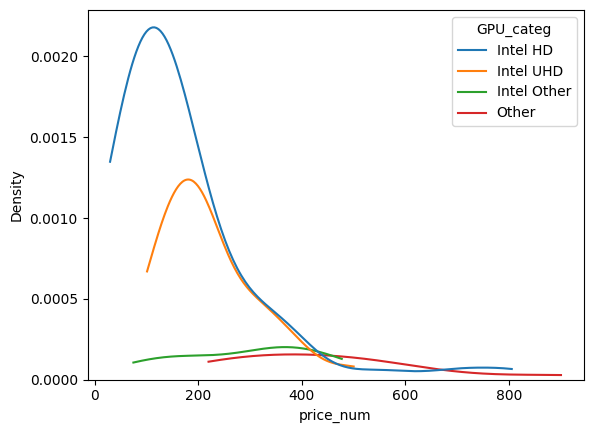

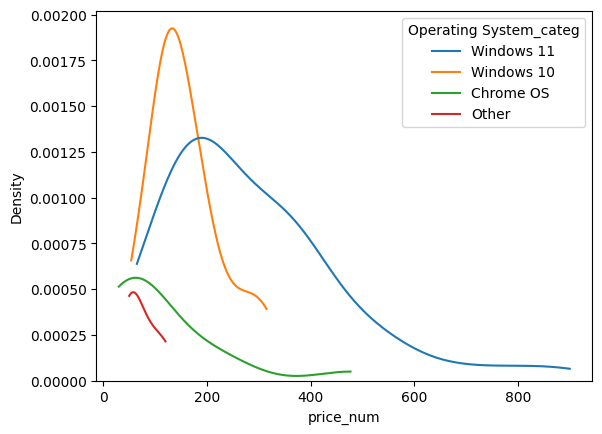

In [60]:
for feature in selected_features:
  sns.kdeplot(df_products_filt_w_features_filt,x='price_num',hue=feature,cut=0)
  plt.show()

In [61]:
import itertools

In [62]:
combinations = list(itertools.combinations(selected_features, 2))

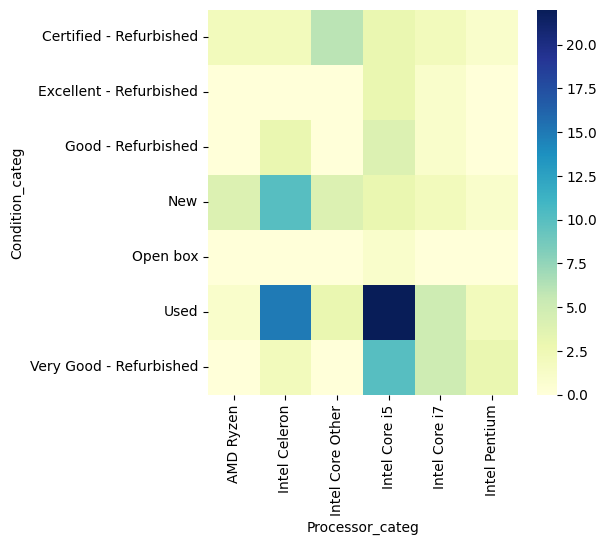

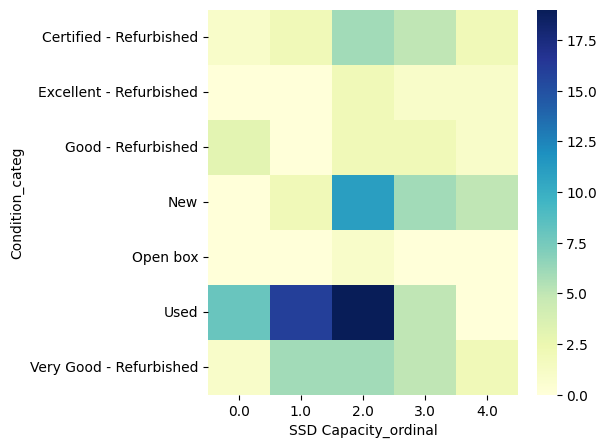

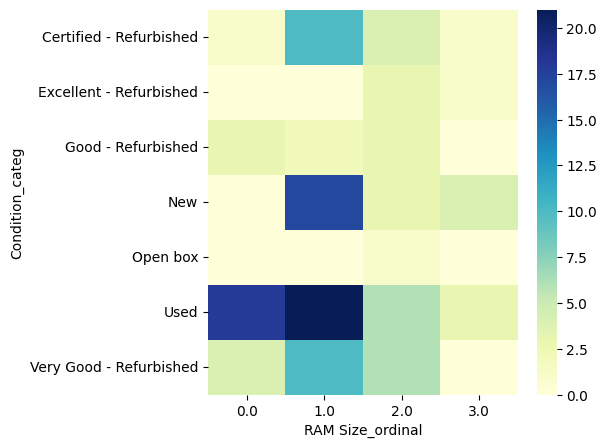

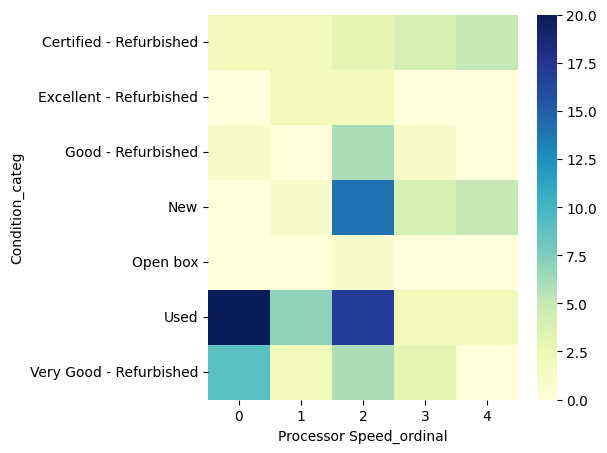

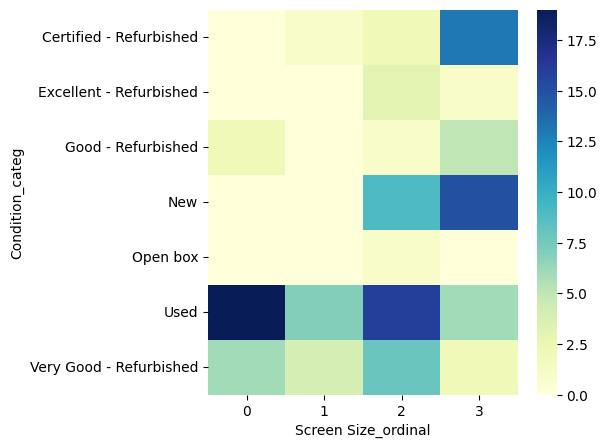

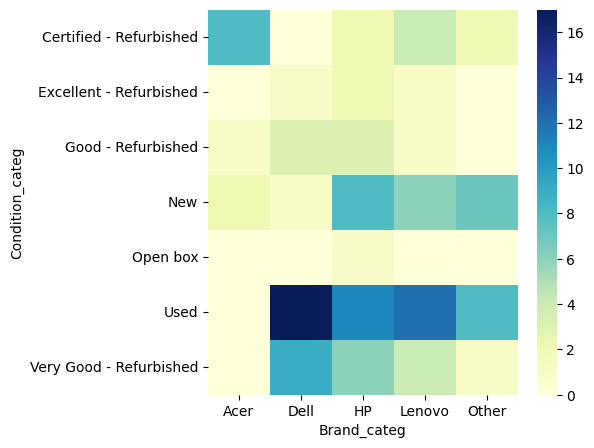

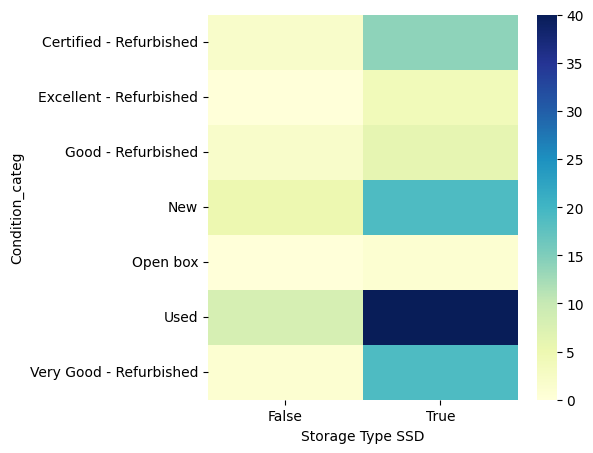

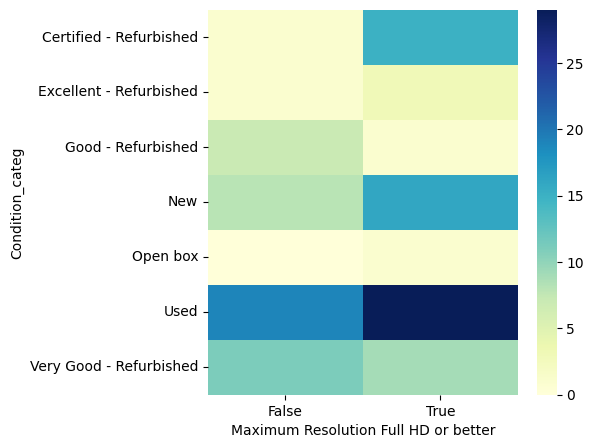

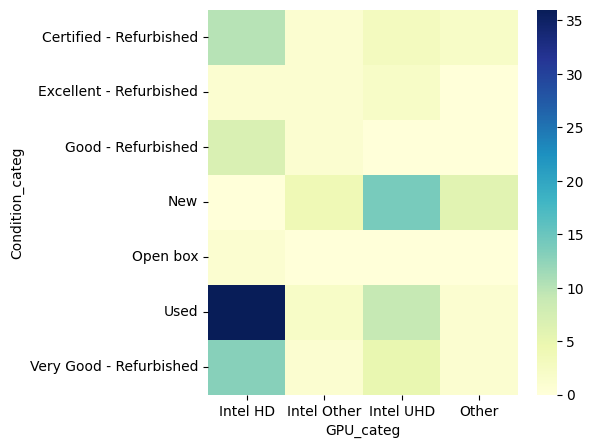

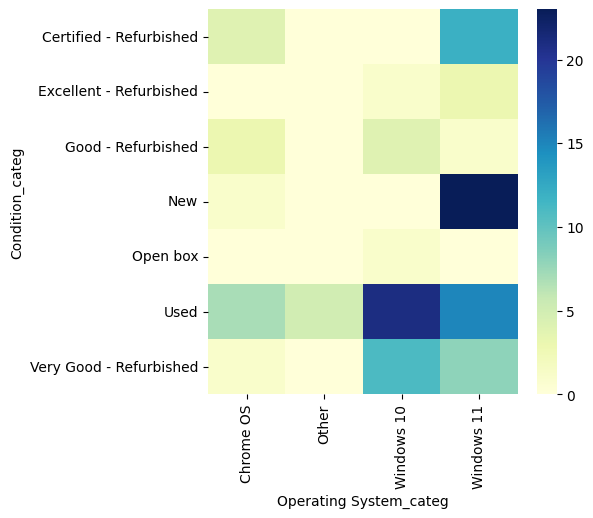

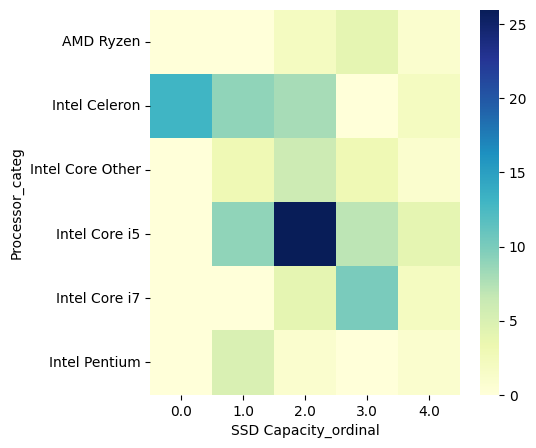

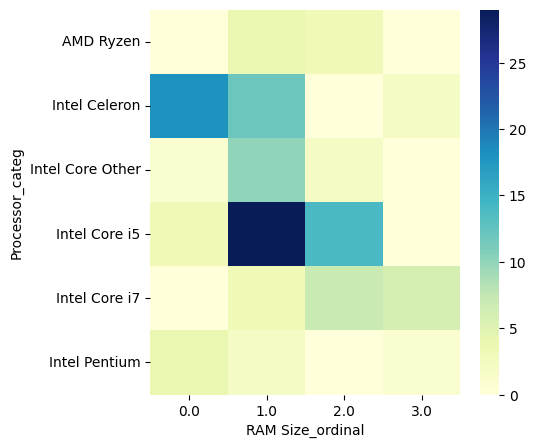

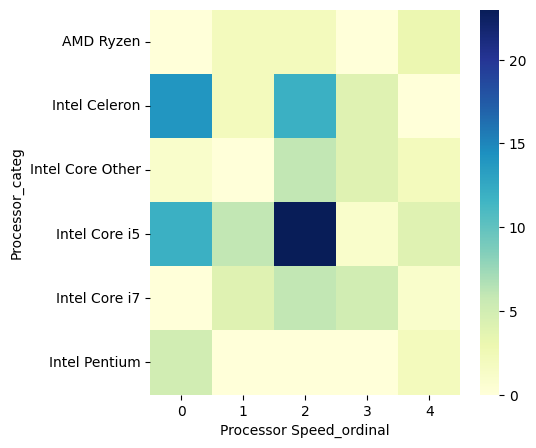

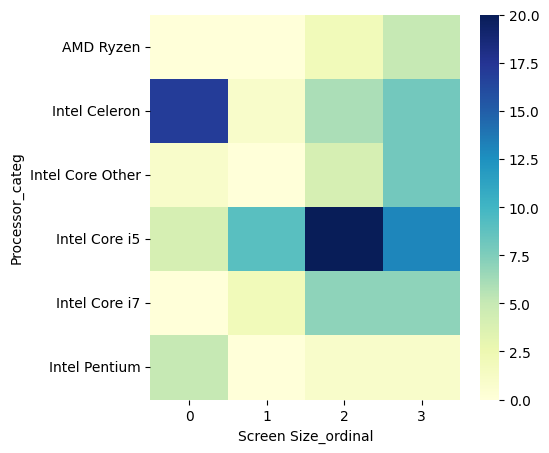

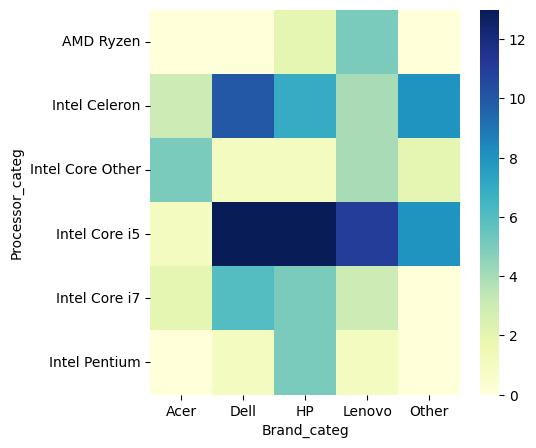

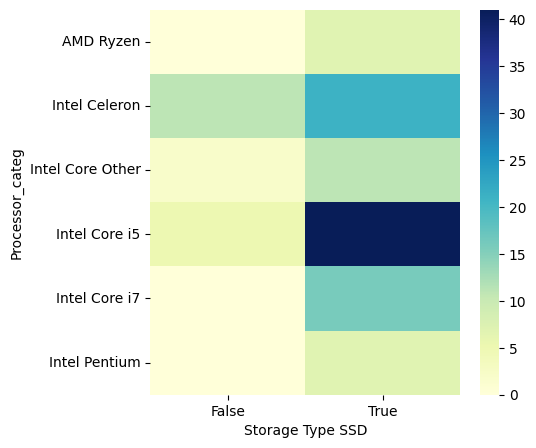

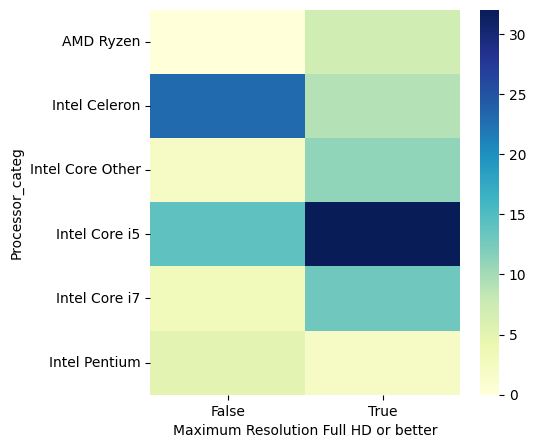

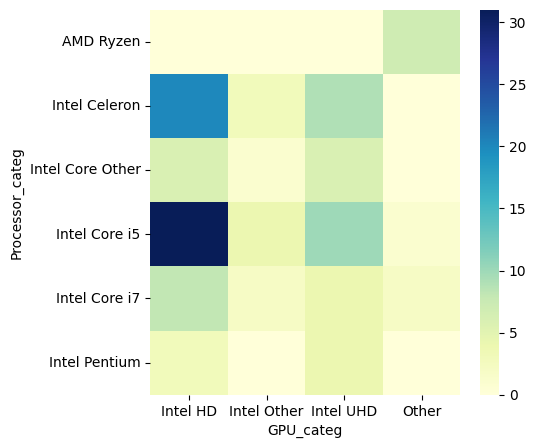

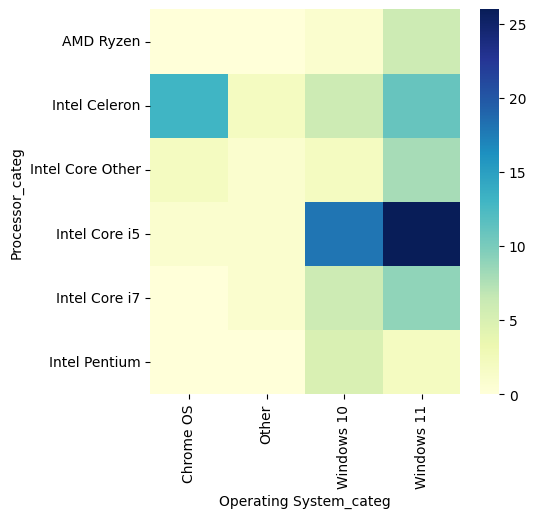

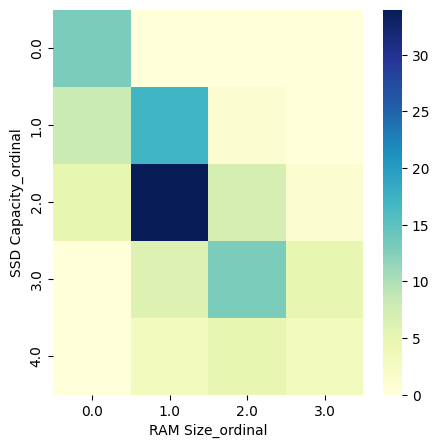

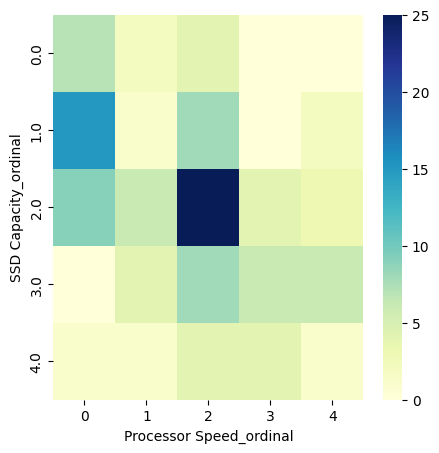

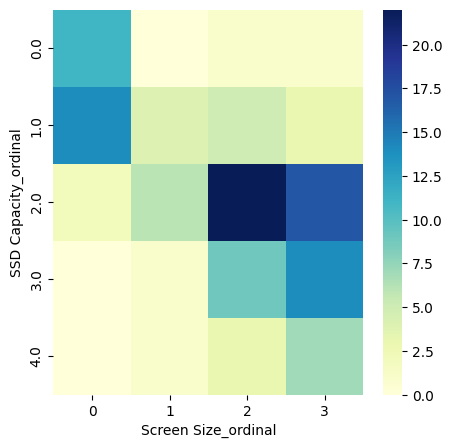

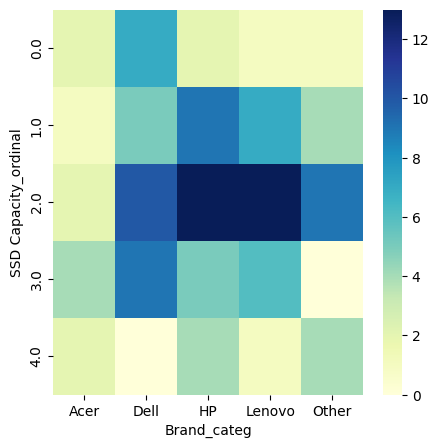

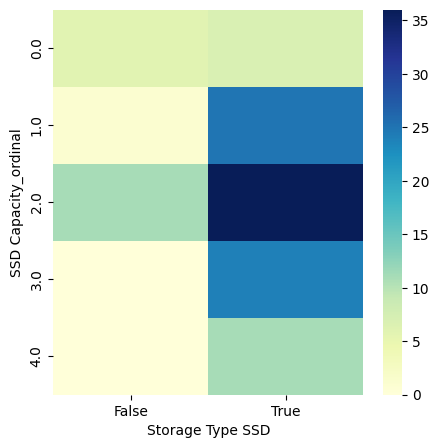

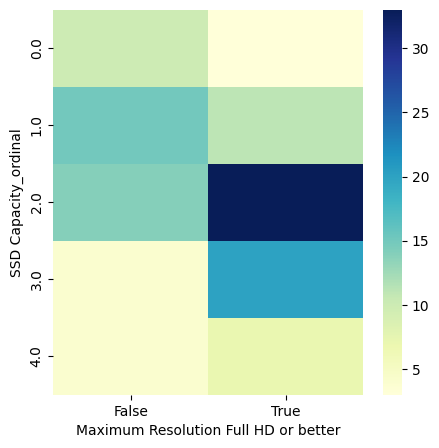

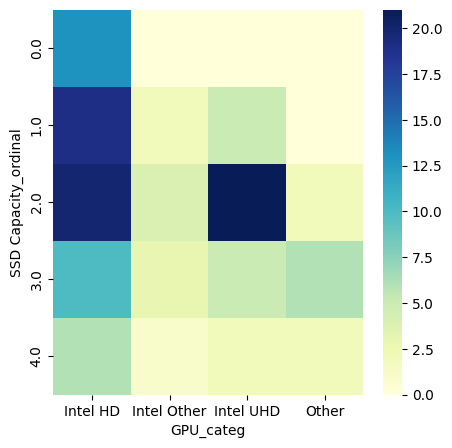

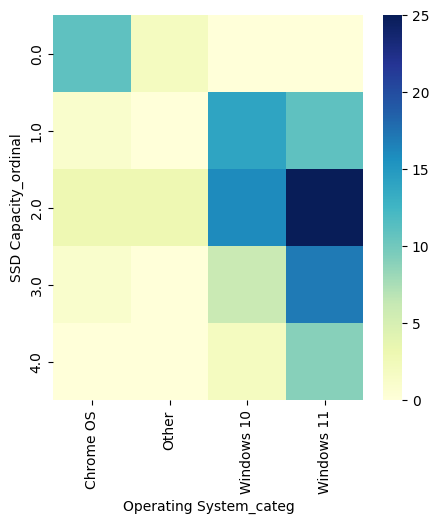

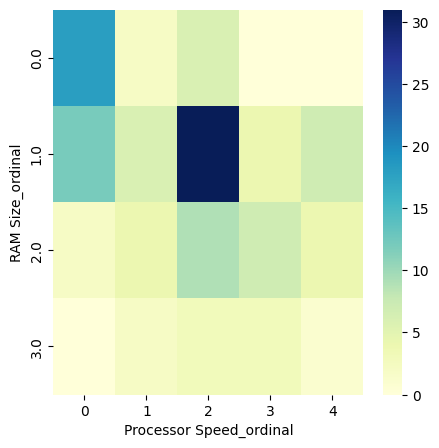

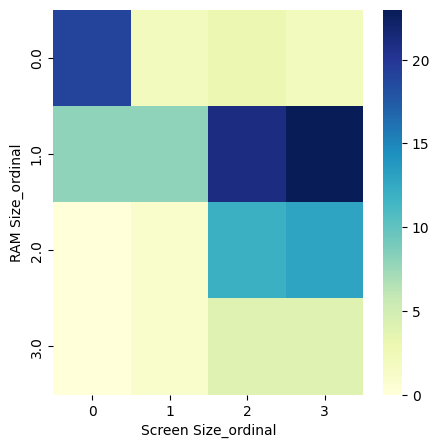

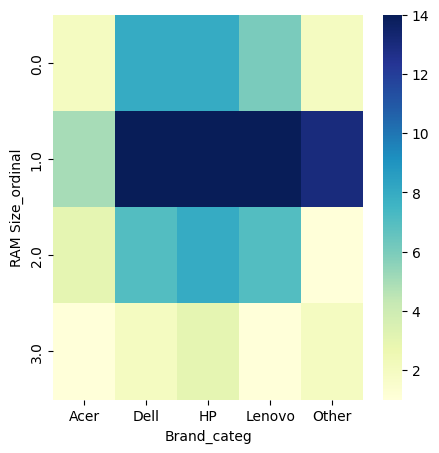

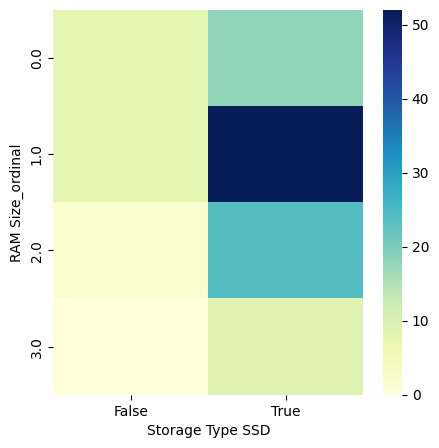

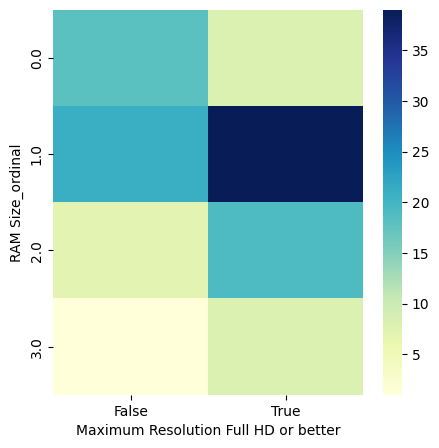

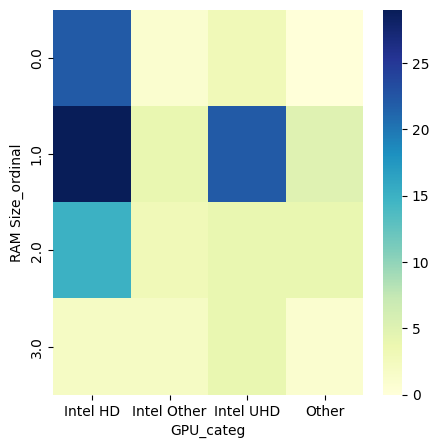

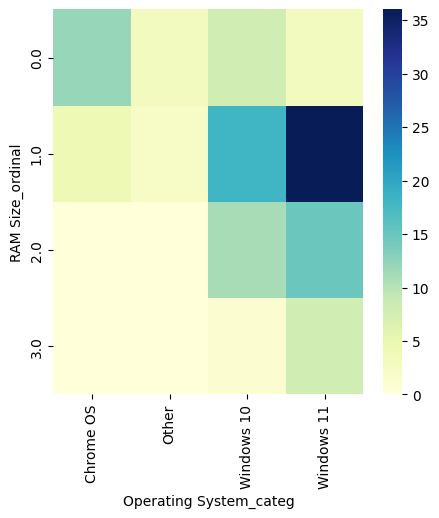

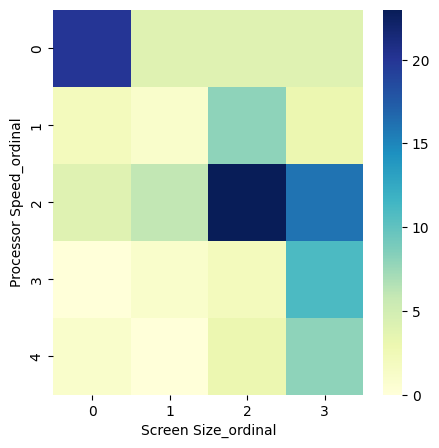

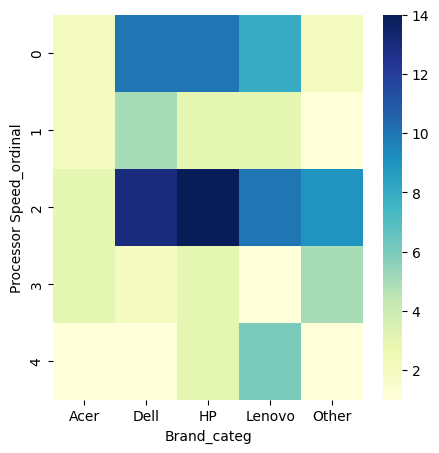

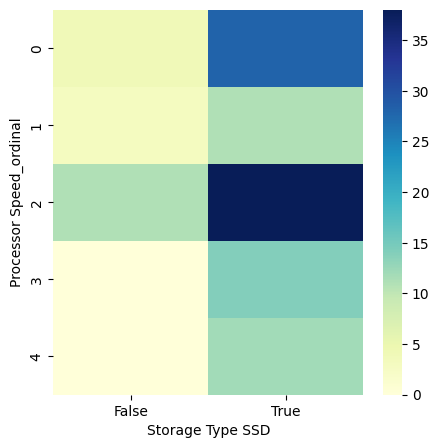

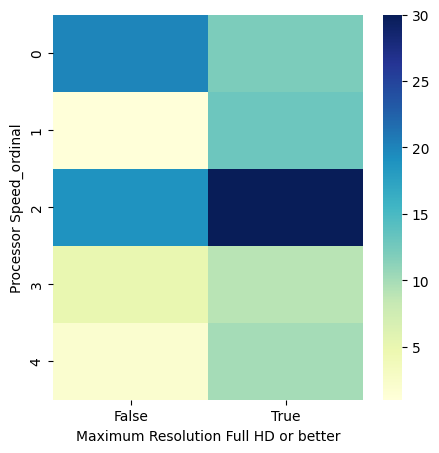

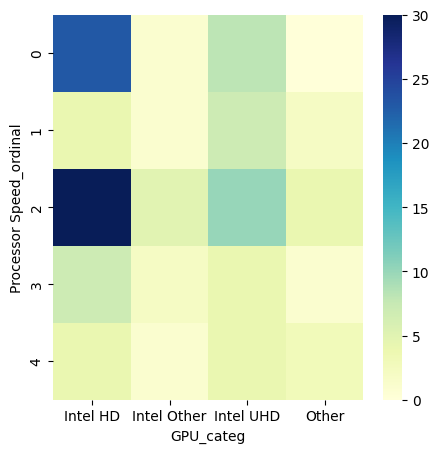

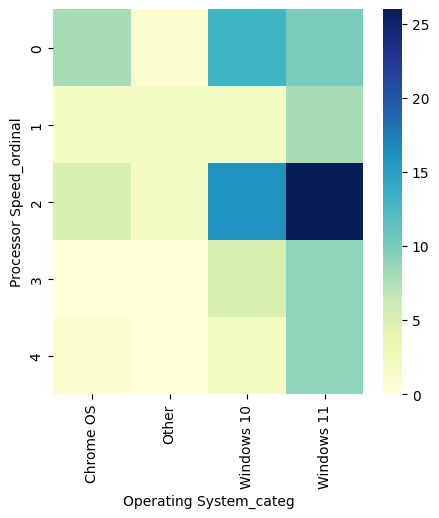

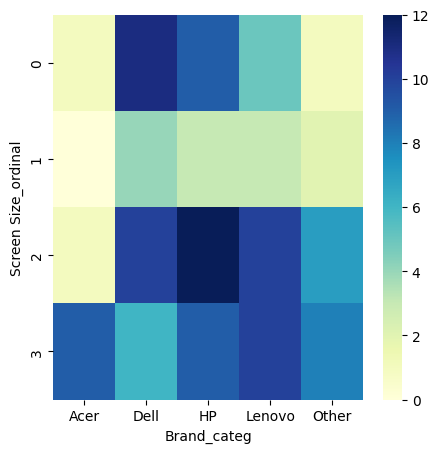

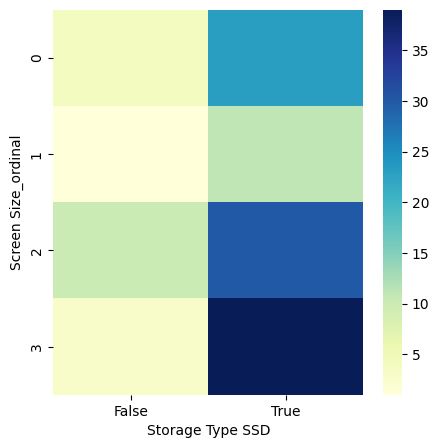

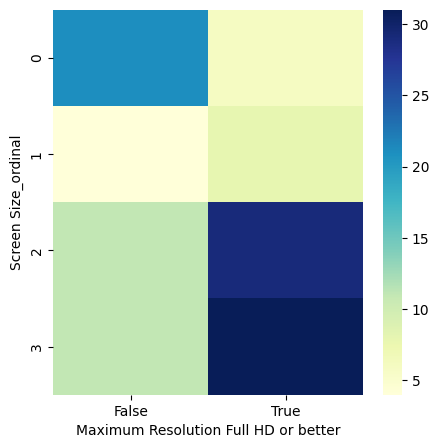

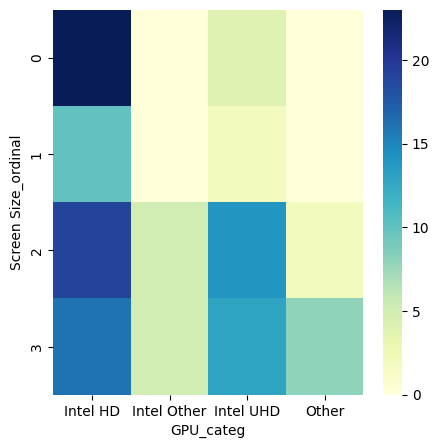

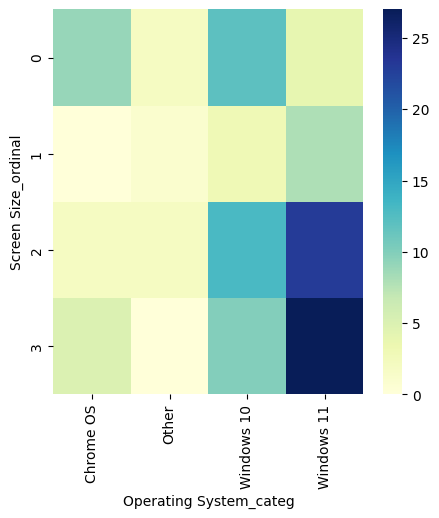

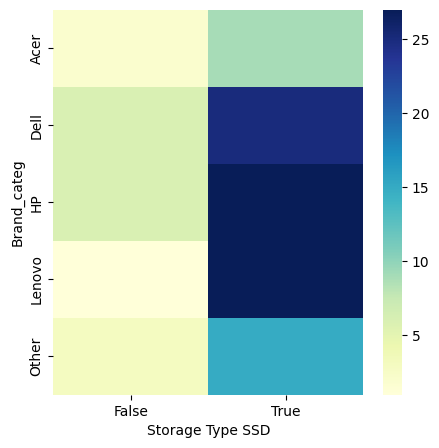

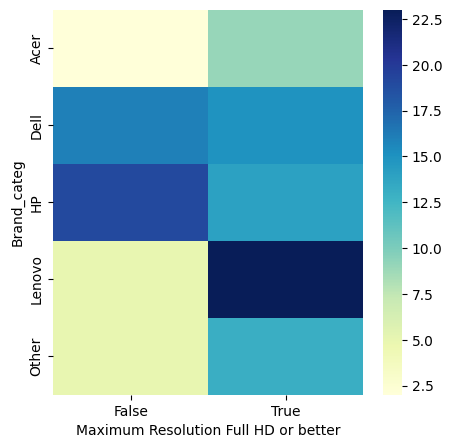

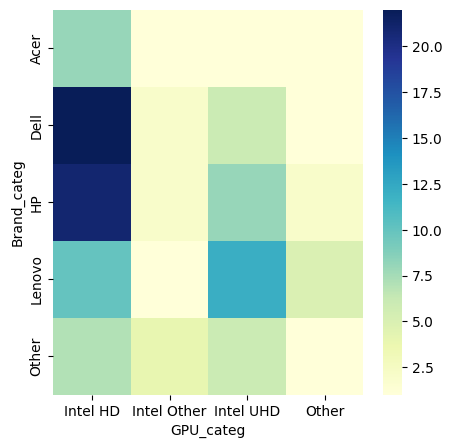

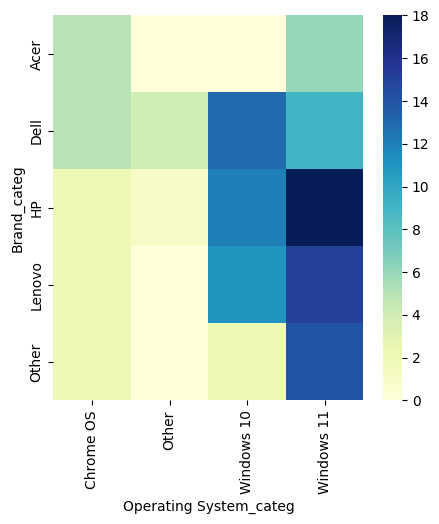

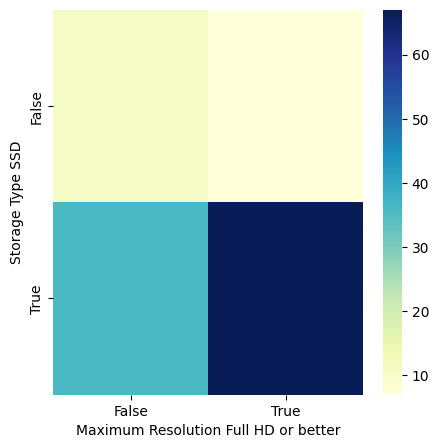

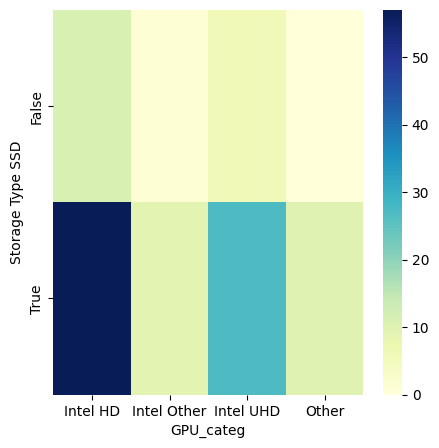

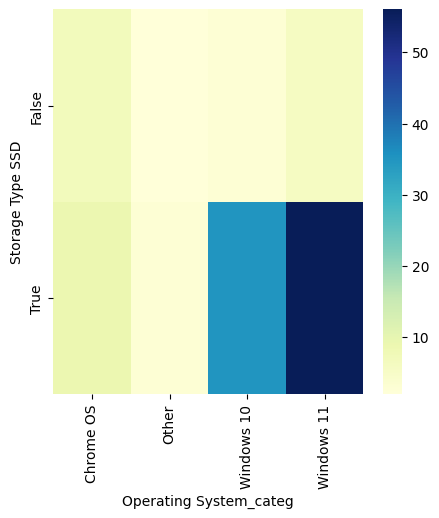

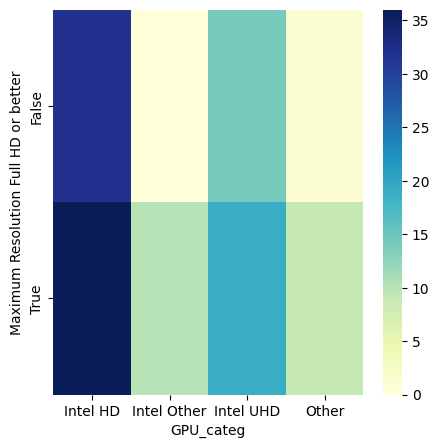

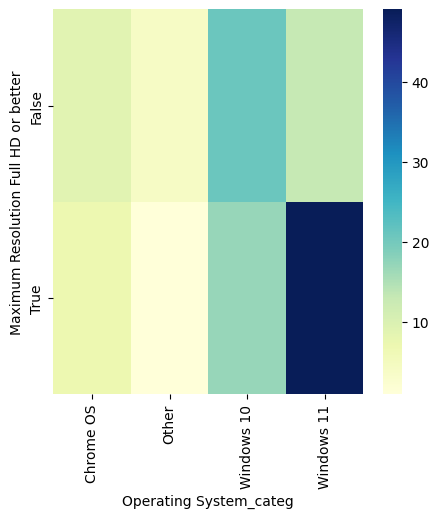

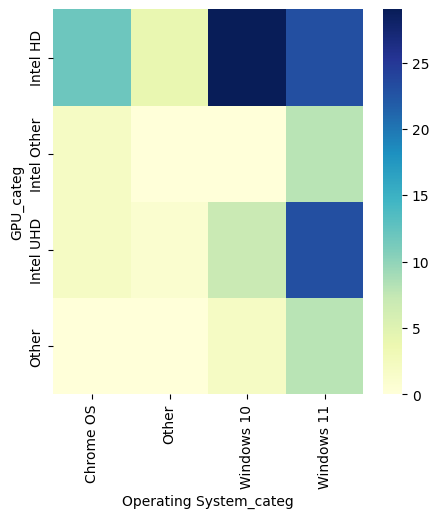

In [63]:
for c1, c2 in combinations:
  df_crosstab = pd.crosstab(df_products_filt_w_features_filt[c1], df_products_filt_w_features_filt[c2], margins = False)
  plt.figure(figsize=(5,5))
  sns.heatmap(df_crosstab,cmap='YlGnBu')
  plt.show()

# Modellezés

In [64]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [65]:
df_for_model = df_products_filt_w_features_filt.loc[:,['price_num']+selected_features].copy()

In [66]:
features_categ = ['Condition_categ', 'Processor_categ','Brand_categ', 'GPU_categ', 'Operating System_categ']

In [67]:
for col in features_categ:
  # Generate dummies for column and drop the first dummy variable
  dummies = pd.get_dummies(df_for_model[col], drop_first=True)
  dummies.columns = [col + '_' + dummy for dummy in dummies.columns]
  # Merge the dummies with the original dataframe
  df_for_model = df_for_model.merge(dummies,left_index=True,right_index=True)
  df_for_model = df_for_model.drop(col,axis=1)

In [68]:
from sklearn.metrics import mean_absolute_error

A dummy változó lesz a baseline.

In [69]:
# Split X and Y
X = df_for_model.loc[:, ~df_for_model.columns.isin(['price_num'])]
y = df_for_model["price_num"]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


# Standardize the features
scaler = StandardScaler()
X_train_stand = scaler.fit_transform(X_train)
X_test_stand = scaler.transform(X_test)

from sklearn.dummy import DummyRegressor
# create a dummy regressor
dummy_reg = DummyRegressor(strategy='mean')
# fit it on the training set
dummy_reg.fit(X_train, y_train)
# make predictions on the test set
predictions_dummy = dummy_reg.predict(X_test)


# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train_stand, y_train)

# Use the forest's predict method on the test data
predictions = rf.predict(X_test_stand)
# Calculate the mean absolute errors
mae_dummy = mean_absolute_error(y_test, predictions_dummy)
mae = mean_absolute_error(y_test, predictions)
# Print out the mean absolute error (mae)
print('Mean Absolute Error Dummy:', round(mae_dummy, 2), 'degrees.')
print('Mean Absolute Error:', round(mae, 2), 'degrees.')

# Calculate feature importance
importances = rf.feature_importances_
df_importance = pd.DataFrame.from_dict(dict(zip(X.columns,importances)),'index').reset_index().rename(columns={'index':'feature',0:'imp'}).sort_values('imp',ascending=False)


Mean Absolute Error Dummy: 164.6 degrees.
Mean Absolute Error: 80.33 degrees.


In [70]:
# limit the features by feature importance
limited_features = df_importance.loc[df_importance['imp']>0.02,'feature'].values

Futtatás szűrt változókkal (legfontosabbak).

In [71]:
# Split X and Y
X = df_for_model.loc[:, limited_features]
y = df_for_model["price_num"]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


# Standardize the features
scaler = StandardScaler()
X_train_stand = scaler.fit_transform(X_train)
X_test_stand = scaler.transform(X_test)

from sklearn.dummy import DummyRegressor
# create a dummy regressor
dummy_reg = DummyRegressor(strategy='mean')
# fit it on the training set
dummy_reg.fit(X_train, y_train)
# make predictions on the test set
predictions_dummy = dummy_reg.predict(X_test)


# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train_stand, y_train)

# Use the forest's predict method on the test data
predictions = rf.predict(X_test_stand)
# Calculate the absolute errors
mae_dummy = mean_absolute_error(y_test, predictions_dummy)
mae = mean_absolute_error(y_test, predictions)
# Print out the mean absolute error (mae)
print('Mean Absolute Error Dummy:', round(mae_dummy, 2), 'degrees.')
print('Mean Absolute Error:', round(mae, 2), 'degrees.')


# Get the names of the selected features
importances = rf.feature_importances_
df_importance2 = pd.DataFrame.from_dict(dict(zip(X.columns,importances)),'index').reset_index().rename(columns={'index':'feature',0:'imp'}).sort_values('imp',ascending=False)

Mean Absolute Error Dummy: 164.6 degrees.
Mean Absolute Error: 76.47 degrees.


Gridsearch futtatás.

Úgy sejtem, hogy itt azért lett a MAE rosszabb, mivel az optimalizálás esetén keresztvalidáció történik.

In [74]:
# Split X and Y
X = df_for_model.loc[:, limited_features]
y = df_for_model["price_num"]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


# Standardize the features
scaler = StandardScaler()
X_train_stand = scaler.fit_transform(X_train)
X_test_stand = scaler.transform(X_test)

from sklearn.dummy import DummyRegressor
# create a dummy regressor
dummy_reg = DummyRegressor(strategy='mean')
# fit it on the training set
dummy_reg.fit(X_train, y_train)
# make predictions on the test set
predictions_dummy = dummy_reg.predict(X_test)


# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train_stand, y_train)

# Use the forest's predict method on the test data
predictions = rf.predict(X_test_stand)
# Calculate the absolute errors
mae_dummy = mean_absolute_error(y_test, predictions_dummy)
mae = mean_absolute_error(y_test, predictions)
# Print out the mean absolute error (mae)
print('Mean Absolute Error Dummy:', round(mae_dummy, 2), 'degrees.')
print('Mean Absolute Error:', round(mae, 2), 'degrees.')

# Use cross-validation to select the optimal number of features to consider at each split
param_grid = {'min_samples_split': list(range(2, 10, 1))}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_stand, y_train)
rf_best = grid_search.best_estimator_
print("grid_search", grid_search.best_estimator_)

# Train the model
rf_best.fit(X_train_stand, y_train)
predictions_best = rf_best.predict(X_test_stand)
mae_best = mean_absolute_error(y_test, predictions_best)
print('Mean Absolute Error Best:', round(mae_best, 2), 'degrees.')


Mean Absolute Error Dummy: 164.6 degrees.
Mean Absolute Error: 76.47 degrees.
grid_search RandomForestRegressor(min_samples_split=6, n_estimators=1000, random_state=42)
Mean Absolute Error Best: 80.14 degrees.


In [81]:
df_result = X_test.merge(y_test,left_index=True,right_index=True)

In [83]:
# use the one with best MAE
df_result['predictions'] = predictions
df_result['predictions_dummy'] = predictions_dummy

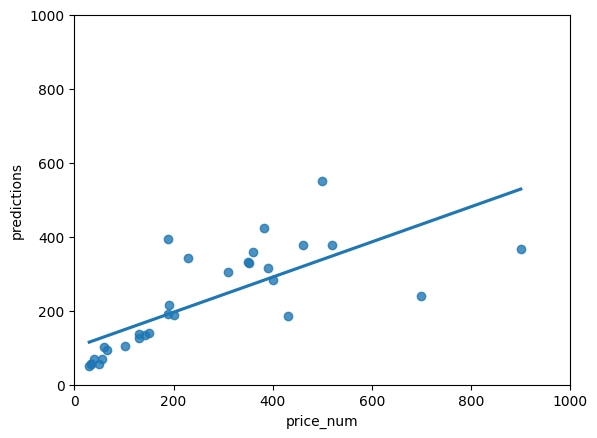

In [104]:
plt.Figure(figsize=(10,10))
sns.regplot(df_result, x='price_num',y='predictions', ci=None)
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.show()

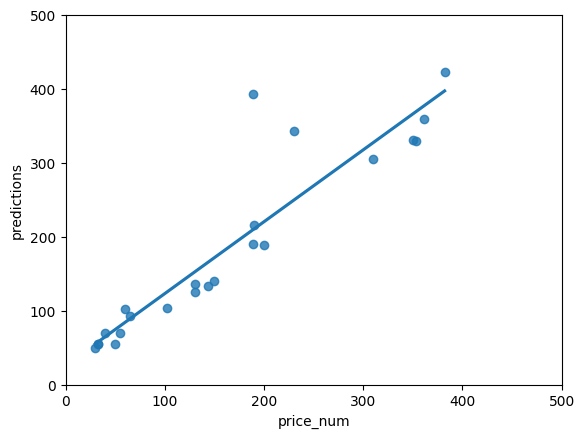

In [109]:
plt.Figure(figsize=(10,10))
sns.regplot(df_result.loc[df_result['price_num']<390], x='price_num',y='predictions', ci=None)
plt.xlim(0,500)
plt.ylim(0,500)
plt.show()

In [106]:
df_result['price_num'].describe()

,price_num
count,31.000000
mean,260.460645
std,212.150524
min,30.000000
25%,83.435000
50%,189.950000
75%,386.490000
max,899.990000


Lehetséges következő lépések:
* más model kipróbálása
* más paraméterekre gridsearch
* más fajta search (pl randomsearch)
* cross validation
* ránézni, hogy miért a magasabb áraknál teljesít rosszabbul